## Imports

In [31]:
from pymongo import MongoClient
client = MongoClient()
db = client.structure_sets

from IPython.display import display
import pandas as pd
pd.options.display.max_rows = 9999

from pymatgen import Element, Structure
from bson.objectid import ObjectId
import math
import time
import pprint
import math
import warnings
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from matminer.figrecipes.plotly.make_plots import PlotlyFig

bonds = {}
bl_pred_dfs = []

### Set up parallel processing units

In [2]:
import ipyparallel as ipp
c = ipp.Client()
print c.ids
# dview = c[:]
lview = c.load_balanced_view()

[0, 1, 2, 3]


## Define functions

### Define the volume predictor

In [13]:
def predict_volume(inp):
    doc = inp[0]
    bonds = inp[1]
    # hacky, had to do this to use parallel engines
    # to run code on the engines, need to pass everything (imports, variables, functions, etc) required to run
    
    """
    Given a Structure (in dict form) and a dictionary of bond length predictions,
    returns a volume prediction and data about which bond was used.
    
    Args:
        doc (dict) : a dictionary corresponding to a Structure (generated via Structure.as_dict())
        bonds (dict) : a dictionary containing bonds with their predicted lengths
                            
    Returns:
        a dictionary containing the following keys:
        name (str) : structure's reduced formula
        actual_volume (float) : volume in the structure dict
        predicted_volume (float) : volume prediction
        num_atoms (int) : number of atoms in the structure
        worst_predicted_bond (str) : ex. 'Al-F' in alphabtical order
        actual_distance (float) : actual distance for the worst_predicted_bond
        expected_distance (float) : predicted distance for the worst_predicted_bond
        _id (ObjectId) : id of the dictionary in mongodb (useful for quick retrievals/deletes/updates)
    """
    
    
    import numpy as np
    from matminer.descriptors.composition_features import get_pymatgen_descriptor
    from pymatgen import Element, Structure
    import warnings
    structure = Structure.from_dict(doc)
    cutoff=4
    ionic_factor = 0.30
    
    smallest_dist = None
    smallest_expected_dist = None
    smallest_ratio = None
    smallest_e1 = None
    smallest_e2 = None
    
    ionic_mix = min(np.std(get_pymatgen_descriptor(structure.composition, 'X')) * ionic_factor, 1)
    
    for site in structure:
        el1 = site.specie

        if el1.atomic_radius:
            r1 = el1.average_ionic_radius * ionic_mix + \
                 el1.atomic_radius * (1-ionic_mix) if el1.average_ionic_radius else el1.atomic_radius
                
            neighbors = structure.get_neighbors(site, el1.atomic_radius + cutoff)
            
            for site2, dist in neighbors:
                el2 = site2.specie
                

                if el2.atomic_radius:
                    r2 = el2.average_ionic_radius * ionic_mix + \
                         el2.atomic_radius * (1-ionic_mix) if el2.average_ionic_radius else el2.atomic_radius
                
                    bond_name = '-'.join(sorted([el1.symbol, el2.symbol]))
                    if bond_name in bonds:
                        expected_dist = bonds[bond_name]['estimates'][-1]
                    else:
                        expected_dist = float(r1+r2)

                    if not smallest_ratio or dist/expected_dist < smallest_ratio:
                        smallest_dist = dist
                        smallest_expected_dist = expected_dist
                        smallest_ratio = dist/expected_dist
                        smallest_e1 = el1
                        smallest_e2 = el2
        else:
            warnings.warn("VolumePredictor: no atomic radius data for "
                          "{}".format(el1))

    if smallest_ratio is None:
        print structure.composition.reduced_formula, doc['_id'], 'FAILED'
        return {'name':structure.composition.reduced_formula, '_id':doc['_id'],
                'status': 'FAILED'}
    
    volume_factor = (1/smallest_ratio)**3
            
    return {'name': structure.composition.reduced_formula, 'actual_volume': structure.volume,
            'predicted_volume': structure.volume * volume_factor, 'num_atoms': structure.composition.num_atoms,
            'worst_predicted_bond': '-'.join(sorted([smallest_e1.symbol, smallest_e2.symbol])),
            'actual_distance': smallest_dist, 'expected_distance': smallest_expected_dist,
            '_id':doc['_id'], 'material_id':doc['material_id']}

### Functions to import previous data

In [82]:
def import_pred_dfs(file_list):
    """
    Import prediction DataFrames based on the list of filenames given
    
    Args:
        file_list (list) : ex. ['bl_pred_df_iter_0.csv', 'bl_pred_df_iter_1.csv']
        
    Returns:
        list of DataFrames
    """
    bl_pred_dfs = []
    for f in file_list:
        df_csv = pd.read_csv(f)
        df_csv.drop('Unnamed: 0', axis=1, inplace=True)
        bl_pred_dfs.append(df_csv)
        
    return bl_pred_dfs


def import_bond_data(f):
    """
    Import database of bond lengths from json 
    
    Args:
        f (json) : ex. 'bonds_0.json'
        
    Returns:
        dict of bonds (see bonds)
    """
    with open(f) as data_file:    
        bonds_from_json = json.load(data_file)
    return bonds_from_json

### Functions for initializing the bonds database (these functions run during iteration 0)

In [60]:
def create_bonds_dict(bl_pred_df_0):
    """
    Initializes the bonds dictionary based the DataFrame corresponding to iteration 0
    """
    
    for b in bl_pred_df_0['worst_predicted_bond'].unique():
        if b not in bonds:
            bonds[b]={'mp_values':{}, 'estimates':[]}

            
def get_mp_values(c):
    """
    Given a material, adds the worst_predicted_bond to the bonds database.
    This function is run on a DataFrame:
        ex. bl_pred_dfs[i].apply(get_mp_values,axis=1)
    
    Args:
        c (Series) : Series corresponding to a single structure
    """
    
    if c['worst_predicted_bond'] in bonds:
        bonds[c['worst_predicted_bond']]['mp_values'][c['material_id']] = c['actual_distance']
    else:
        print c['worst_predicted_bond'], 'DNE. Creating entry in bonds dict..'
        bonds[c['worst_predicted_bond']]={'mp_values':{c['material_id']:c['actual_distance']}, 'estimates':[]}

### Functions to retrieve n% of the the worst bond predictions for an iteration

In [16]:
# def get_worst_predicted_bonds_avg_minus_median():
#     bond_estimate_data = []
#     percent_to_return = 0.1
#     num_bonds_to_change = int(percent_to_return*len(bonds))
#     for b in bonds:
#         b_median = np.median(bonds[b]['mp_values'].values())
#         b_est = bonds[b]['estimates'][-1]
#         b_dist = abs(b_median-b_est)

#         bond_estimate_data.append({'bond_name':b, 'median-estimate': b_dist})

#     bond_estimate_data_df = pd.DataFrame(bond_estimate_data)

#     return bond_estimate_data_df.sort_values('median-estimate',ascending=False)[:num_bonds_to_change]['bond_name'].tolist()


def get_worst_predicted_bonds_avg_score(bl_pred_df, percent_to_return=10):
    """
    Given a dataframe corresponding to an iteration, retrieves n% of the worst performing bond
    length predictions, based on which bonds had the highest average percent error.
    
    Args:
        bl_pred_df (DataFrame) : ex. corresponds to material data
        
    Returns:
        list of worst performing bond names
    """    
    bond_estimate_data = []
    percent_to_return = float(percent_to_return)/100.0
    num_bonds_to_change = int(percent_to_return*len(bonds))
    for b in bl_pred_df['worst_predicted_bond'].unique():
        df =  bl_pred_df[bl_pred_df['worst_predicted_bond']==b]
        mean_score = df['score'].mean()
        bond_estimate_data.append({'bond_name':b, 'mean_score': np.mean(mean_score)})

    bond_estimate_data_df = pd.DataFrame(bond_estimate_data)

    return bond_estimate_data_df.sort_values('mean_score',ascending=False)[:num_bonds_to_change]['bond_name'].tolist()
    

### Update bond length estimates for a specified list of bonds

In [17]:
def update_estimates(bl_pred_df, iter_num, bonds_to_update,weight=0.5):
    """
    Given a dataframe corresponding to an iteration and a list of worst performing bonds,
    move the bond length estimates closer to the Materials Project median by a specified weight
    
    Args:
        bl_pred_df (DataFrame) : ex. corresponds to material data
        iter_num (int): the iteration number
        bonds_to_update(list): list of bond names that performed the worst
        weight(float): weight the movement from old prediction to MP median
    """   
    
    for b in bonds_to_update:
        if len(bonds[b]['estimates'])<iter_num+2: # after iter 0, want at most 2 estimate entries, 3 after iter 1, etc.
            if len(bonds[b]['estimates']) == 0: # first estimate is always the OG ionic mix prediction
                df = bl_pred_df[bl_pred_df['worst_predicted_bond']==b]
                new_estimate = df['expected_distance'].mean()
            else:
                new_estimate = weight*(np.median(bonds[b]['mp_values'].values())) + (1-weight)*(bonds[b]['estimates'][-1])
                
            bonds[b]['estimates'].append(new_estimate)
            

### Scoring functions, distance and percent error

In [18]:
def dist_df(c, pred_vol='predicted_volume', act_vol='actual_volume', num_atoms='num_atoms'):
    """
    Returns a score based on distance from the y=x line
    
    Args:
        c (Series) : Series corresponding to a single structure
        pred_vol (str) : column name that contains the predicted volume
        act_vol (str) : column name that contains the actual volume
        num_atoms (str) : column name that contains the number of atoms
                            
    Returns:
        a float value of the distance away from the optimal line
    """
    
    # define the optimal line here using two points
    # line is y = x
    x1 = 0
    y1 = 0
    x2 = 100
    y2 = 100
    
    # set x3, y3 as the point
    x3 = c[pred_vol]/c[num_atoms]
    y3 = c[act_vol]/c[num_atoms]
        
    return score(x1, y1, x2, y2, x3,y3)


def dist(x1, y1, x2, y2, x3,y3):
    """
    Helper function
    """
    px = x2-x1
    py = y2-y1

    temp = px*px + py*py
    u = ((x3 - x1)*px + (y3 - y1)*py)/float(temp)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u*px
    y = y1 + u*py
    dx = x - x3
    dy = y - y3
    
    dist = math.sqrt(dx*dx + dy*dy)
    return dist


def percent_error_df(c, pred_vol='predicted_volume', act_vol='actual_volume', num_atoms='num_atoms'):
    """
    Returns a score based on percent error between actual and predicted
    
    Args:
        c (Series) : Series corresponding to a single structure
        pred_vol (str) : column name that contains the predicted volume
        act_vol (str) : column name that contains the actual volume
        num_atoms (str) : column name that contains the number of atoms
                            
    Returns:
        a float value corresponding to percent error
    """
    return percent_error(c[pred_vol]/c[num_atoms], c[act_vol]/c[num_atoms])
    

def percent_error(calculcated, actual):
    """
    Helper function
    """
    return abs(calculcated-actual)/actual

### Some functions to help analyze data

In [61]:
def display_bond_data(b):
    """
    Prints out bond information in the bonds dictionary and all materials that used that bond for
    volume prediction in each iteration
    
    Args:
        b (str): bond name ex. 'O-P'
        bonds (dict): dict of bonds
        bl_pred_dfs (list): list of DataFrames
    """
    pprint.pprint(bonds[b])
    for df in bl_pred_dfs:
        display(df[df['worst_predicted_bond']==b])
    
    
def display_material_data(c):
    """
    Prints out a material's predictions/informations in all of the iterations run so far
    
    Args:
        c (str): material name ex. 'IZr' # might want to change this to using mat_id down the line
        bl_pred_dfs (list): list of DataFrames
    """
    for df in bl_pred_dfs:
        display(df[df['name']==c])

        
def get_material(mat_id, collection=db.materials_project):
    """
    Given a material id, find it in the mongo database. This is useful for editing or removing values
    
    Args:
        mat_id (str): Materials Project id
        collection: collection name
    """
    cursor = collection.find({"_id": ObjectId(obj_id_to_find)})
    print cursor.count(), 'results found'

    
def delete_material(mat_id, collection=db.materials_project):
    """
    Given a material id, delete it in the mongo database.
    
    Args:
        mat_id (str): Materials Project id
        collection: collection name
    """
    result = collection.delete_one({'_id': ObjectId(mat_id)})
    print 'deleted', result.deleted_count
    

## MAIN

In [20]:
# to test changes, run on a small section of the data set
# acquire a random sample from the materials_project db, and add it to a temporary db
# materials_project_test_set

# cursor = db.materials_project.aggregate(
#     [
#         {"$sample": {"size": 1000}}
#     ]
# )
# for doc in cursor:
#     db.mp_test.insert_one(doc)
cursor = db.mp_test.find()
cursor.count()

1000

In [33]:
# Careful!! Running this section will wipe all previous data and start from scratch

"""
bonds is a dictionary organized in the following manner:
    key: 'element1-element2' ex. 'C-Cl'
    'mp_values': dictionary of bonds lengths calculated from the structures in Materials Project
                 ex. bonds['C-Cl'][mp_values] = {'mp-12345':1.0, 'mp-67890':2.0}
    'estimates': array of the last estimated value used (entry 0 should be estimate from old vol predictor)
                 ex. bonds['C-Cl']['estimates'] = [1, 1.5, 2, 2.25, 2.4]
"""
bonds = {}


"""
bl_pred_dfs is a list of pandas DataFrames, where each index corresponds to an iteration.
    bl_pred_dfs[0] is the initial iteration DataFrame
    bl_pred_dfs[-1] is the most recent iteration DataFrame
"""
bl_pred_dfs = []


"""
bonds_updated_this_iter is a list of lists containing the names of the bonds that were updated in
an iteration. bonds_updated_this_iter[0] returns the bonds that were updated after the initial iteration, etc.
"""
bonds_updated_this_iter = []

"""
scores is a list containing the average score of the iteration (percent error)
iter_run_times is a list containing the times it took to run each iteration
"""
scores = []
iter_run_times = []

In [53]:
"""
Main function. This section runs through all of the given database, estimating the bond lengths for
each structure, and storing the worst estimate in bond_length_predictions[iter_index]. After each iteration
through the database, updates 10% worst performing bond by moving the estimate closer
to the median of the values found.

Run this section after setting the number of iterations and how many bonds to change per iteration.

"""

def run_predictor(weight_decay_per_iter, weight, collection=db.materials_project,
                  init_iter=0, num_iter=1, percent_bonds_to_change_per_iter=10):
    cursor = collection.find()

    for i in range(init_iter, init_iter+num_iter):
        iter_start_time = time.time()
        print '\n################### ROUND', i, '#######################'
        bond_length_predictions = []

        lim = 1000
        iter_num = 0
        d = []
        print len(bond_length_predictions), 'structures processed'
        while len(bond_length_predictions) < cursor.count():
            temp_cursor = cursor.clone()
            temp_cursor.skip(lim*iter_num)
            temp_cursor.limit(lim)
            d = lview.map_sync(predict_volume, [[doc,bonds] for doc in temp_cursor])
            bond_length_predictions += d
            iter_num+=1
            print len(bond_length_predictions), 'structures processed'

        print 'making dataframe'
        cols = ['name', 'material_id', 'worst_predicted_bond', 'expected_distance', 'actual_distance',
                'predicted_volume', 'actual_volume','num_atoms', '_id']
        bl_pred_dfs.append(pd.DataFrame(bond_length_predictions, columns=cols))


        print 'calculating score'
        bl_pred_dfs[i]['score'] = bl_pred_dfs[i].apply(percent_error_df, args=('predicted_volume','actual_volume','num_atoms'), axis=1)
        score_this_iter = bl_pred_dfs[i]['score'].mean()    
        scores.append(score_this_iter)


        if i == 0: # initialization of bonds dict estimates
            print 'initializing bonds dict (iteration 0)'
            # create a dictionary bonds
            print 'creating bonds dict'
            create_bonds_dict(bl_pred_dfs[0])
            # gets all of the materials project data for bond lengths and puts it in 'mp_values'
            print 'collecting Materials Project bond lengths'
            bl_pred_dfs[0].apply(get_mp_values,axis=1)
            # initialize our first estimate
            print 'initializing estimates'
            update_estimates(bl_pred_dfs[i], i, bonds.keys(), weight)

        print 'adding new bonds'
        # if a new bond shows up, add it to the dict!
        for b in bl_pred_dfs[i]['worst_predicted_bond'].unique():
            if b not in bonds:
                bonds[b]={'mp_values':{}, 'estimates':[]}
                df = bl_pred_dfs[i][bl_pred_dfs[i]['worst_predicted_bond']==b]
                for index, row in df.iterrows():
                    bonds[b]['mp_values'][row['material_id']] = row['actual_distance']
                new_estimate = df['expected_distance'].median()
                bonds[b]['estimates'] = [new_estimate]
                print 'NEW BOND', b, 'added to bonds dict'

        print 'updating MP values'
        # for a bond, if a new material now uses it, add its MP length into the dict
        for b in bl_pred_dfs[i]['worst_predicted_bond'].unique():
            df = bl_pred_dfs[i][bl_pred_dfs[i]['worst_predicted_bond']==b]
            for index, row in df.iterrows():
                if row['material_id'] not in bonds[b]['mp_values']:
                    bonds[b]['mp_values'][row['material_id']] = row['actual_distance']


        print 'updating bonds dict and adding new estimates for 10%'
        bonds_updated_this_iter.append(get_worst_predicted_bonds_avg_score(bl_pred_dfs[i])) # get back a list of bond length estimates updated
        update_estimates(bl_pred_dfs[i], i, bonds_updated_this_iter[i], weight)
        weight = weight * weight_decay_per_iter


        # write bl_pred_dfs[i], bonds_updated_this_iter[i], bonds to csv
        print 'saving dataframe and bonds'
        filepath = 'bl_pred_df_iter_'+str(i)+'.csv'
        bl_pred_dfs[i].to_csv(filepath)
        with open('bonds_'+str(i)+'.json', 'w') as fp:
            json.dump(bonds, fp, sort_keys=True)

        iter_end_time = time.time()
        iter_run_times.append(iter_end_time-iter_start_time)

    

In [55]:
"""
Before running the predictor, set these variables each time! This allows you to space out iterations
instead of having to run them all at once.
"""

init_iter = 0
num_iter = 2
percent_bonds_to_change_per_iter = 10
weight_decay_per_iter = 0.9
weight = 0.5 * pow(weight_decay_per_iter, init_iter)
collection = db.materials_project

In [56]:
run_predictor(weight_decay_per_iter=weight_decay_per_iter, weight=weight, collection=collection,
              init_iter=init_iter, num_iter=num_iter,
              percent_bonds_to_change_per_iter=percent_bonds_to_change_per_iter)


################### ROUND 0 #######################
0 structures processed
1000 structures processed
making dataframe
calculating score
initializing bonds dict (iteration 0)
creating bonds dict
collecting Materials Project bond lengths
initializing estimates
adding new bonds
updating MP values
updating bonds dict and adding new estimates for 10%
saving dataframe and bonds

################### ROUND 1 #######################
0 structures processed
1000 structures processed
making dataframe
calculating score
adding new bonds
updating MP values
updating bonds dict and adding new estimates for 10%
saving dataframe and bonds


In [ ]:
print 'score per iteration:', scores
print 'hours to run each iteration:', np.array(iter_run_times)/3600
print 'num bonds in database:', len(bonds)

## Plots

In [83]:
file_list = ['MP_set_data/bl_pred_df_iter_0.csv',
            'MP_set_data/bl_pred_df_iter_1.csv',
            'MP_set_data/bl_pred_df_iter_2.csv',
            'MP_set_data/bl_pred_df_iter_3.csv',
            'MP_set_data/bl_pred_df_iter_4.csv',
            'MP_set_data/bl_pred_df_iter_5.csv',
            'MP_set_data/bl_pred_df_iter_6.csv',
            'MP_set_data/bl_pred_df_iter_7.csv',
            'MP_set_data/bl_pred_df_iter_8.csv',
            'MP_set_data/bl_pred_df_iter_9.csv']
bl_pred_dfs = import_pred_dfs(file_list)

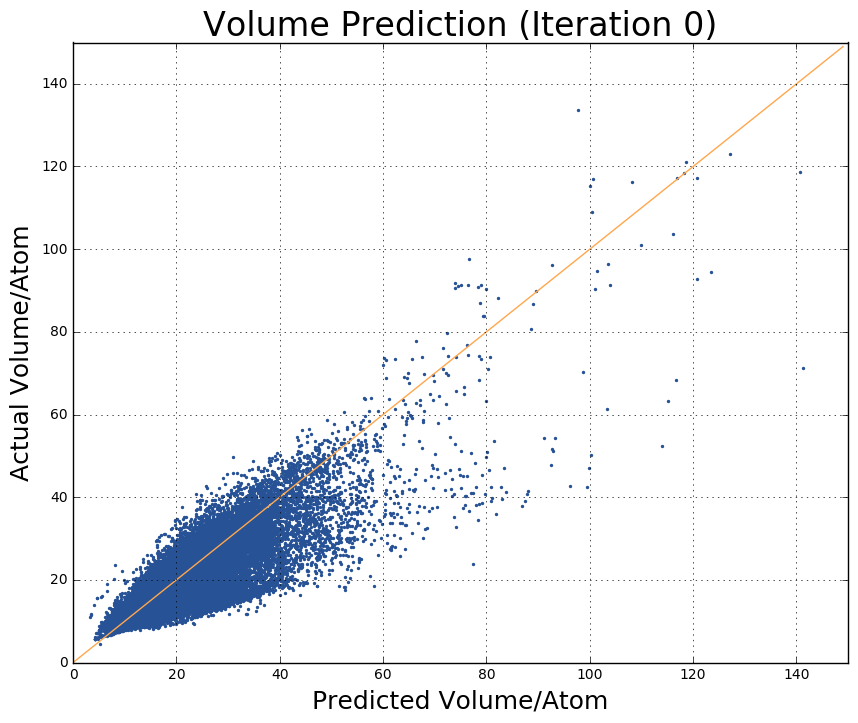

In [84]:
d1 = bl_pred_dfs[0]

x = (d1['predicted_volume']/d1['num_atoms']).tolist()
y = (d1['actual_volume']/d1['num_atoms']).tolist()

a1 = np.arange(150)
a2 = a1*0.8

plt.scatter(x,y,s=2,color='#285296')
plt.plot(range(0,150),range(0,150), '#FFA74D')

plt.xlabel('Predicted Volume/Atom',fontsize=18)
plt.ylabel('Actual Volume/Atom',fontsize=18)
plt.title('Volume Prediction (Iteration 0)',fontsize=24)
axes = plt.gca()
axes.set_xlim([0,150])
axes.set_ylim([0,150])
plt.grid()
plt.show()

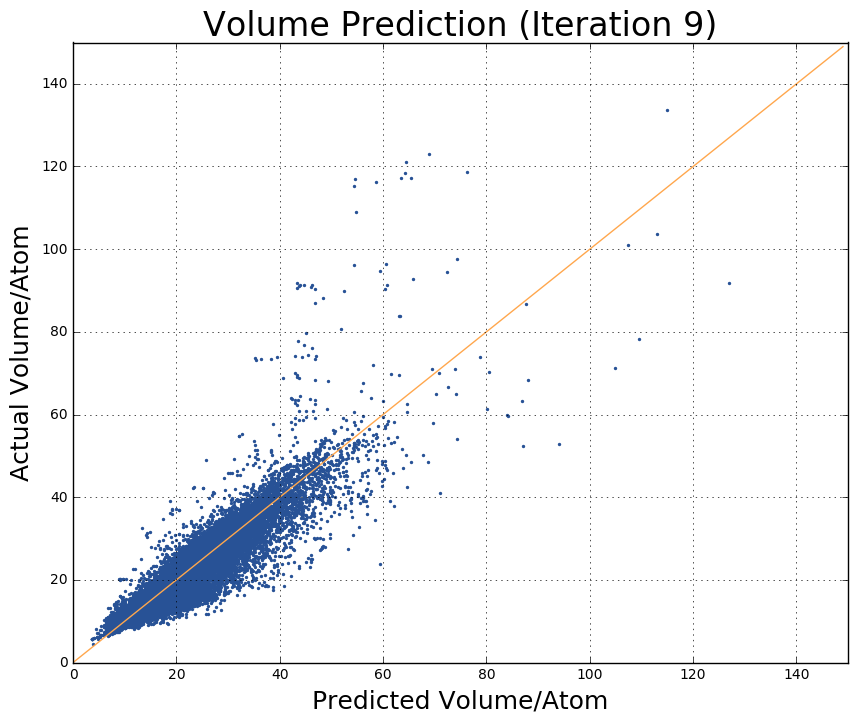

In [101]:
d1 = bl_pred_dfs[-1]

x = (d1['predicted_volume']/d1['num_atoms']).tolist()
y = (d1['actual_volume']/d1['num_atoms']).tolist()

plt.scatter(x,y,s=2,color='#285296')
plt.plot(range(0,150), '#FFA74D')

plt.xlabel('Predicted Volume/Atom',fontsize=18)
plt.ylabel('Actual Volume/Atom',fontsize=18)
plt.title('Volume Prediction (Iteration 9)',fontsize=24)
axes = plt.gca()
axes.set_xlim([0,150])
axes.set_ylim([0,150])
plt.grid()
plt.show()


# interactive plot a bit laggy
# p = PlotlyFig(x_title='Volume Prediction (Iteration 9)', y_title='Final Prediction',
#           plot_title='Initial vs Final Predictions', height=600, width=800,
#           plot_mode='notebook', margin_left=150, textsize=25,)

# p.xy_plot(x_col=x, y_col=y, marker_outline_width=1,
#             text=d1['name']+' '+d1['material_id'], 
#             add_xy_plot=[{'x_col': [0, 250], 'y_col': [0, 250],
#                           'color': 'green', 'mode': 'lines',
#                           'legend': None,'text': None, 'size': None},
#                         ],)

In [77]:
# plot bond stuff here
x = []
y = []
z = []
for b in bonds:
    x.append(bonds[b]['estimates'][0])
    y.append(bonds[b]['estimates'][-1])
    z.append(bonds[b]['estimates'][-1] - bonds[b]['estimates'][0])

p = PlotlyFig(x_title='Initial Prediction (sum of atomic radii)', y_title='Final Prediction',
          plot_title='Initial vs Final Predictions', height=600, width=800,
          plot_mode='notebook', margin_left=150, textsize=25,)

p.xy_plot(x_col=x, y_col=y, marker_outline_width=1,
            text=bonds.keys(), 
            add_xy_plot=[{'x_col': [0, 5], 'y_col': [0, 5],
                          'color': 'green', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                        ],)



p = PlotlyFig(x_title='Initial Prediction (sum of atomic radii)', y_title='Final Prediction Delta',
          plot_title='Initial Predictions vs Final Delta', height=600, width=800,
          plot_mode='notebook', margin_left=150, textsize=25,)


p.xy_plot(x_col=x, y_col=z, marker_outline_width=1,
            text=bonds.keys(), 
            add_xy_plot=[{'x_col': [0, 5], 'y_col': [1, 1],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                         {'x_col': [0, 5], 'y_col': [0, 0],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                         {'x_col': [0, 5], 'y_col': [-1, -1],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None}
                        ],
             )

## Analysis

In [99]:
bl_pred_dfs[-1].sort_values('score',ascending=False).head(100)

,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
33683,K6Al11Si13Ag5O48,mp-686585,K-K,3.680926,2.717342,4929.533357,1983.203276,83.0,58f02b3e7f079f2488b363ea,1.485642
18292,BaMn4O8,mp-767732,Ba-Ba,3.907427,2.976381,2234.638084,987.643089,78.0,58f022057f079f2488b327cb,1.262597
61274,RbMn4O8,mp-769768,Rb-Rb,3.932607,3.004961,338.484334,151.012695,13.0,58f03aec7f079f2488b3cfb1,1.241430
16561,Np,mp-11534,Np-Np,3.239797,2.486265,326.180227,147.416579,8.0,58f020f07f079f2488b32108,1.212643
22533,RbCr4O8,mp-19029,Rb-Rb,3.932607,3.020974,333.671496,151.258009,13.0,58f024967f079f2488b3385c,1.205976
8483,Pu,mp-571261,Pu-Pu,3.157988,2.428037,77.427935,35.191046,2.0,58f01bd47f079f2488b3017a,1.200217
31525,Na8Ga42O67,mp-685217,Na-Na,2.986138,2.298735,3200.854643,1460.169638,117.0,58f029ec7f079f2488b35b7c,1.192111
45681,Pu,mp-613989,Pu-Pu,3.157988,2.463412,618.354062,293.506153,16.0,58f032157f079f2488b392c8,1.106784
43101,Rb2Fe4O7,mp-771380,Rb-Rb,3.932607,3.097952,359.917045,175.948186,13.0,58f030a27f079f2488b388b4,1.045585
38858,Np,mp-7098,Np-Np,3.239797,2.557950,150.039346,73.846163,4.0,58f02e367f079f2488b37821,1.031783


In [ ]:
e1 = Element('O')
e2 = Element('Xe')
print e1.atomic_radius, e1.average_ionic_radius
print e2.atomic_radius, e2.average_ionic_radius

In [100]:
display_material_data('Ba')

,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,4.3,4.491476,56.219939,64.069643,1.0,58f01c557f079f2488b304d8,0.122518
9680,Ba,mp-122,Ba-Ba,4.3,4.356368,61.204517,63.643146,1.0,58f01c887f079f2488b30627,0.038317
15012,Ba,mp-570384,Ba-Ba,4.3,4.130241,296.704551,262.932884,4.0,58f020017f079f2488b31afb,0.128442
29880,Ba,mp-56,Ba-Ba,4.3,4.478557,113.032817,127.706664,2.0,58f028f27f079f2488b3550f,0.114903
61168,Ba,mp-605790,Ba-Ba,4.3,3.975379,79.957104,63.181129,1.0,58f03add7f079f2488b3cf47,0.265522


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,4.015541,4.491476,45.784371,64.069643,1.0,58f01c557f079f2488b304d8,0.285397
9680,Ba,mp-122,Ba-Ba,4.015541,4.356368,49.843709,63.643146,1.0,58f01c887f079f2488b30627,0.216825
15012,Ba,mp-570384,Ba-Ba,4.015541,4.130241,241.630129,262.932884,4.0,58f020017f079f2488b31afb,0.081020
29880,Ba,mp-56,Ba-Ba,4.015541,4.478557,92.051619,127.706664,2.0,58f028f27f079f2488b3550f,0.279195
61168,Ba,mp-605790,Ba-Ba,4.015541,3.975379,65.115433,63.181129,1.0,58f03add7f079f2488b3cf47,0.030615


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,4.015541,4.491476,45.784371,64.069643,1.0,58f01c557f079f2488b304d8,0.285397
9680,Ba,mp-122,Ba-Ba,4.015541,4.356368,49.843709,63.643146,1.0,58f01c887f079f2488b30627,0.216825
15012,Ba,mp-570384,Ba-Ba,4.015541,4.130241,241.630129,262.932884,4.0,58f020017f079f2488b31afb,0.081020
29880,Ba,mp-56,Ba-Ba,4.015541,4.478557,92.051619,127.706664,2.0,58f028f27f079f2488b3550f,0.279195
61168,Ba,mp-605790,Ba-Ba,4.015541,3.975379,65.115433,63.181129,1.0,58f03add7f079f2488b3cf47,0.030615


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,4.015541,4.491476,45.784371,64.069643,1.0,58f01c557f079f2488b304d8,0.285397
9680,Ba,mp-122,Ba-Ba,4.015541,4.356368,49.843709,63.643146,1.0,58f01c887f079f2488b30627,0.216825
15012,Ba,mp-570384,Ba-Ba,4.015541,4.130241,241.630129,262.932884,4.0,58f020017f079f2488b31afb,0.081020
29880,Ba,mp-56,Ba-Ba,4.015541,4.478557,92.051619,127.706664,2.0,58f028f27f079f2488b3550f,0.279195
61168,Ba,mp-605790,Ba-Ba,4.015541,3.975379,65.115433,63.181129,1.0,58f03add7f079f2488b3cf47,0.030615


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.970776,4.491476,44.270183,64.069643,1.0,58f01c557f079f2488b304d8,0.309030
9680,Ba,mp-122,Ba-Ba,3.970776,4.356368,48.195270,63.643146,1.0,58f01c887f079f2488b30627,0.242726
15012,Ba,mp-570384,Ba-Ba,3.970776,4.130241,233.638899,262.932884,4.0,58f020017f079f2488b31afb,0.111412
29880,Ba,mp-56,Ba-Ba,3.970776,4.478557,89.007273,127.706664,2.0,58f028f27f079f2488b3550f,0.303033
61168,Ba,mp-605790,Ba-Ba,3.970776,3.975379,62.961925,63.181129,1.0,58f03add7f079f2488b3cf47,0.003469


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.93761,4.491476,43.170088,64.069643,1.0,58f01c557f079f2488b304d8,0.326201
9680,Ba,mp-122,Ba-Ba,3.93761,4.356368,46.997639,63.643146,1.0,58f01c887f079f2488b30627,0.261544
15012,Ba,mp-570384,Ba-Ba,3.93761,4.130241,227.833076,262.932884,4.0,58f020017f079f2488b31afb,0.133493
29880,Ba,mp-56,Ba-Ba,3.93761,4.478557,86.795482,127.706664,2.0,58f028f27f079f2488b3550f,0.320353
61168,Ba,mp-605790,Ba-Ba,3.93761,3.975379,61.397349,63.181129,1.0,58f03add7f079f2488b3cf47,0.028233


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.922684,4.491476,42.681051,64.069643,1.0,58f01c557f079f2488b304d8,0.333833
9680,Ba,mp-122,Ba-Ba,3.922684,4.356368,46.465242,63.643146,1.0,58f01c887f079f2488b30627,0.269910
15012,Ba,mp-570384,Ba-Ba,3.922684,4.130241,225.252146,262.932884,4.0,58f020017f079f2488b31afb,0.143309
29880,Ba,mp-56,Ba-Ba,3.922684,4.478557,85.812249,127.706664,2.0,58f028f27f079f2488b3550f,0.328052
61168,Ba,mp-605790,Ba-Ba,3.922684,3.975379,60.701830,63.181129,1.0,58f03add7f079f2488b3cf47,0.039241


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.915296,4.491476,42.440350,64.069643,1.0,58f01c557f079f2488b304d8,0.337590
9680,Ba,mp-122,Ba-Ba,3.915296,4.356368,46.203200,63.643146,1.0,58f01c887f079f2488b30627,0.274027
15012,Ba,mp-570384,Ba-Ba,3.915296,4.130241,223.981830,262.932884,4.0,58f020017f079f2488b31afb,0.148141
29880,Ba,mp-56,Ba-Ba,3.915296,4.478557,85.328308,127.706664,2.0,58f028f27f079f2488b3550f,0.331841
61168,Ba,mp-605790,Ba-Ba,3.915296,3.975379,60.359501,63.181129,1.0,58f03add7f079f2488b3cf47,0.044659


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.90987,4.491476,42.264116,64.069643,1.0,58f01c557f079f2488b304d8,0.340341
9680,Ba,mp-122,Ba-Ba,3.90987,4.356368,46.011342,63.643146,1.0,58f01c887f079f2488b30627,0.277042
15012,Ba,mp-570384,Ba-Ba,3.90987,4.130241,223.051746,262.932884,4.0,58f020017f079f2488b31afb,0.151678
29880,Ba,mp-56,Ba-Ba,3.90987,4.478557,84.973982,127.706664,2.0,58f028f27f079f2488b3550f,0.334616
61168,Ba,mp-605790,Ba-Ba,3.90987,3.975379,60.108858,63.181129,1.0,58f03add7f079f2488b3cf47,0.048626


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
9345,Ba,mp-10679,Ba-Ba,3.907427,4.491476,42.184970,64.069643,1.0,58f01c557f079f2488b304d8,0.341576
9680,Ba,mp-122,Ba-Ba,3.907427,4.356368,45.925179,63.643146,1.0,58f01c887f079f2488b30627,0.278396
15012,Ba,mp-570384,Ba-Ba,3.907427,4.130241,222.634049,262.932884,4.0,58f020017f079f2488b31afb,0.153267
29880,Ba,mp-56,Ba-Ba,3.907427,4.478557,84.814856,127.706664,2.0,58f028f27f079f2488b3550f,0.335862
61168,Ba,mp-605790,Ba-Ba,3.907427,3.975379,59.996295,63.181129,1.0,58f03add7f079f2488b3cf47,0.050408


In [97]:
display_bond_data('F-Ir')

{u'estimates': [1.7592405686665178, 1.8312186852066596, 1.860369822405417],
 u'mp_values': {u'mp-11172': 1.9161957663293876,
                u'mp-11174': 1.972768527805143,
                u'mp-13545': 1.9693936252637625,
                u'mp-13841': 1.8901978371642159,
                u'mp-2437': 2.0371200609949924,
                u'mp-560553': 1.875188568460098,
                u'mp-662534': 1.8669004206041742}}


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.762133,2.037120,66.635413,102.952969,8.0,58f01b827f079f2488b2ff49,0.352759
18795,LiIrF6,mp-11172,F-Ir,1.727004,1.916196,79.429510,108.497859,8.0,58f022577f079f2488b329c2,0.267916
32303,IrF6,mp-560553,F-Ir,1.778993,1.875189,378.548231,443.336508,28.0,58f02a657f079f2488b35e86,0.146138
35005,IrF4,mp-13841,F-Ir,1.768832,1.890198,112.565680,137.362449,10.0,58f02c067f079f2488b36914,0.180521


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.759241,2.037120,66.307811,102.952969,8.0,58f01b827f079f2488b2ff49,0.355941
18795,LiIrF6,mp-11172,F-Ir,1.759241,1.916196,83.960929,108.497859,8.0,58f022577f079f2488b329c2,0.226151
32303,IrF6,mp-560553,F-Ir,1.759241,1.875189,366.078607,443.336508,28.0,58f02a657f079f2488b35e86,0.174265
35005,IrF4,mp-13841,F-Ir,1.759241,1.890198,110.744440,137.362449,10.0,58f02c067f079f2488b36914,0.193779


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.831219,2.037120,74.784162,102.952969,8.0,58f01b827f079f2488b2ff49,0.273608
18795,LiIrF6,mp-11172,F-Ir,1.831219,1.916196,94.693937,108.497859,8.0,58f022577f079f2488b329c2,0.127228
32303,IrF6,mp-560553,F-Ir,1.831219,1.875189,412.875668,443.336508,28.0,58f02a657f079f2488b35e86,0.068708
35005,IrF4,mp-13841,F-Ir,1.831219,1.890198,124.901275,137.362449,10.0,58f02c067f079f2488b36914,0.090717
39896,BaIrF6,mp-13545,F-Ir,1.831219,1.969394,99.256503,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.196061
55274,AgIrF7,mp-662534,F-Ir,1.831219,1.866900,570.253837,604.242187,36.0,58f037857f079f2488b3b841,0.056250


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.831219,2.037120,74.784162,102.952969,8.0,58f01b827f079f2488b2ff49,0.273608
18795,LiIrF6,mp-11172,F-Ir,1.831219,1.916196,94.693937,108.497859,8.0,58f022577f079f2488b329c2,0.127228
32303,IrF6,mp-560553,F-Ir,1.831219,1.875189,412.875668,443.336508,28.0,58f02a657f079f2488b35e86,0.068708
35005,IrF4,mp-13841,F-Ir,1.831219,1.890198,124.901275,137.362449,10.0,58f02c067f079f2488b36914,0.090717
39896,BaIrF6,mp-13545,F-Ir,1.831219,1.969394,99.256503,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.196061
55274,AgIrF7,mp-662534,F-Ir,1.831219,1.866900,570.253837,604.242187,36.0,58f037857f079f2488b3b841,0.056250


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.831219,2.037120,74.784162,102.952969,8.0,58f01b827f079f2488b2ff49,0.273608
18795,LiIrF6,mp-11172,F-Ir,1.831219,1.916196,94.693937,108.497859,8.0,58f022577f079f2488b329c2,0.127228
32303,IrF6,mp-560553,F-Ir,1.831219,1.875189,412.875668,443.336508,28.0,58f02a657f079f2488b35e86,0.068708
35005,IrF4,mp-13841,F-Ir,1.831219,1.890198,124.901275,137.362449,10.0,58f02c067f079f2488b36914,0.090717
39896,BaIrF6,mp-13545,F-Ir,1.831219,1.969394,99.256503,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.196061
55274,AgIrF7,mp-662534,F-Ir,1.831219,1.866900,570.253837,604.242187,36.0,58f037857f079f2488b3b841,0.056250


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.831219,2.037120,74.784162,102.952969,8.0,58f01b827f079f2488b2ff49,0.273608
18795,LiIrF6,mp-11172,F-Ir,1.831219,1.916196,94.693937,108.497859,8.0,58f022577f079f2488b329c2,0.127228
32303,IrF6,mp-560553,F-Ir,1.831219,1.875189,412.875668,443.336508,28.0,58f02a657f079f2488b35e86,0.068708
35005,IrF4,mp-13841,F-Ir,1.831219,1.890198,124.901275,137.362449,10.0,58f02c067f079f2488b36914,0.090717
39896,BaIrF6,mp-13545,F-Ir,1.831219,1.969394,99.256503,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.196061
55274,AgIrF7,mp-662534,F-Ir,1.831219,1.866900,570.253837,604.242187,36.0,58f037857f079f2488b3b841,0.056250


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.831219,2.037120,74.784162,102.952969,8.0,58f01b827f079f2488b2ff49,0.273608
18795,LiIrF6,mp-11172,F-Ir,1.831219,1.916196,94.693937,108.497859,8.0,58f022577f079f2488b329c2,0.127228
32303,IrF6,mp-560553,F-Ir,1.831219,1.875189,412.875668,443.336508,28.0,58f02a657f079f2488b35e86,0.068708
35005,IrF4,mp-13841,F-Ir,1.831219,1.890198,124.901275,137.362449,10.0,58f02c067f079f2488b36914,0.090717
39896,BaIrF6,mp-13545,F-Ir,1.831219,1.969394,99.256503,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.196061
55274,AgIrF7,mp-662534,F-Ir,1.831219,1.866900,570.253837,604.242187,36.0,58f037857f079f2488b3b841,0.056250


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.86037,2.037120,78.412781,102.952969,8.0,58f01b827f079f2488b2ff49,0.238363
11506,K2IrF6,mp-11174,F-Ir,1.86037,1.972769,119.499939,142.494538,9.0,58f01dc77f079f2488b30d49,0.161372
18795,LiIrF6,mp-11172,F-Ir,1.86037,1.916196,99.288602,108.497859,8.0,58f022577f079f2488b329c2,0.084880
32303,IrF6,mp-560553,F-Ir,1.86037,1.875189,432.908900,443.336508,28.0,58f02a657f079f2488b35e86,0.023521
35005,IrF4,mp-13841,F-Ir,1.86037,1.890198,130.961637,137.362449,10.0,58f02c067f079f2488b36914,0.046598
39896,BaIrF6,mp-13545,F-Ir,1.86037,1.969394,104.072549,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.157053
55274,AgIrF7,mp-662534,F-Ir,1.86037,1.866900,597.923250,604.242187,36.0,58f037857f079f2488b3b841,0.010458


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.86037,2.037120,78.412781,102.952969,8.0,58f01b827f079f2488b2ff49,0.238363
11506,K2IrF6,mp-11174,F-Ir,1.86037,1.972769,119.499939,142.494538,9.0,58f01dc77f079f2488b30d49,0.161372
18795,LiIrF6,mp-11172,F-Ir,1.86037,1.916196,99.288602,108.497859,8.0,58f022577f079f2488b329c2,0.084880
32303,IrF6,mp-560553,F-Ir,1.86037,1.875189,432.908900,443.336508,28.0,58f02a657f079f2488b35e86,0.023521
35005,IrF4,mp-13841,F-Ir,1.86037,1.890198,130.961637,137.362449,10.0,58f02c067f079f2488b36914,0.046598
39896,BaIrF6,mp-13545,F-Ir,1.86037,1.969394,104.072549,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.157053
55274,AgIrF7,mp-662534,F-Ir,1.86037,1.866900,597.923250,604.242187,36.0,58f037857f079f2488b3b841,0.010458


,name,material_id,worst_predicted_bond,expected_distance,actual_distance,predicted_volume,actual_volume,num_atoms,_id,score
7922,IrF3,mp-2437,F-Ir,1.86037,2.037120,78.412781,102.952969,8.0,58f01b827f079f2488b2ff49,0.238363
11506,K2IrF6,mp-11174,F-Ir,1.86037,1.972769,119.499939,142.494538,9.0,58f01dc77f079f2488b30d49,0.161372
18795,LiIrF6,mp-11172,F-Ir,1.86037,1.916196,99.288602,108.497859,8.0,58f022577f079f2488b329c2,0.084880
32303,IrF6,mp-560553,F-Ir,1.86037,1.875189,432.908900,443.336508,28.0,58f02a657f079f2488b35e86,0.023521
35005,IrF4,mp-13841,F-Ir,1.86037,1.890198,130.961637,137.362449,10.0,58f02c067f079f2488b36914,0.046598
39896,BaIrF6,mp-13545,F-Ir,1.86037,1.969394,104.072549,123.462742,8.0,58f02ecc7f079f2488b37c2f,0.157053
55274,AgIrF7,mp-662534,F-Ir,1.86037,1.866900,597.923250,604.242187,36.0,58f037857f079f2488b3b841,0.010458


### getting the coefficients of variance of MP data - shows how spread the bond lengths are

In [ ]:
test_df_data = []
for b in bonds:
    x = bonds[b]['mp_values'].values()
    test_df_data.append({'bond_name':b, 'CV': np.std(x)/np.mean(x), 'std_dev':np.std(x), 'mean':np.mean(x),
                         'variance':np.var(x)})

bond_cv_scores = pd.DataFrame(test_df_data)
display(bond_cv_scores.sort_values('CV',ascending=False).head(25))